# Non-signal data exercise

In this exercise you take on the role of a senior data analyst correcting mistakes made by a junior analyst. Your consulting company has received the MysteryData data set, and your goal is to build a classifier out of it, and evaluate how well the classifer works. You assigned the job to junior trainee Tux the Linux Penguin (who works for food).

Tux is very excited to work on the data and has produced very promising results. What Tux does not yet know is that MysteryData is actually just random non-signal data where the features x and the class label y are independent of each other - it is not possible to learn anything meaningful from this data. Tux has never taken any of the UTU data analytics courses and has not noticed this. You should help Tux to correct the analyses, so you do not end up reporting incorrect results to your customers.

You will write your answers inside this notebook. If all your answers are correct, your explanations thorough, and you solve the bonus questions, you will get a bonus point. Use written text, code, printouts or visualizations in you answers as needed. Return both this notebook filled (rename it lastname_firstname_studentid.ipynb), as well as a pdf export of the same notebook (same naming, but .pdf instead).

The analysed problem is a binary classification task. We will follow the convention of using +1 to represent the positive class, and -1 the negative. In all but one task we will use area under ROC curve (AUC) to evaluate how well the classifier predicts. For binary classification tasks AUC and c-index are equivalent, 0.5 means random performance and 1.0 perfect predictions. The "true" AUC you would expect to see on a large enough sample of independent test data for any classifier trained on non-signal data is 0.5.

Note that amount of samples, features, and class distribution for MysteryData can differ in different parts of the exercise (these are always written in comments above the code generating the data). Also, in one case there will be a data set on which it is possible to learn better than random classifier.

Some notes on the codes:
- we use predict_proba() instead of predict() when using AUC, because the predicted class probabilities are needed for computing AUC properly (predict() returns only +1/-1 values)
- random seeds are fixed to guarantee that re-running the codes gives same results

In [6]:
%matplotlib inline
import numpy as np

#The data, trust me, you can't learn anything useful from this
def load_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of features
    #positives: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X = rand_state.randn(samples, features)
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    y = rand_state.permutation(y)
    return X, y

# Part 1: some elementary mistakes

## Lesson 1.1: never trust your ----- set performance

The first analysis done by Tux contains an obvious elementary mistake.

In [7]:
#100 samples, 100 features, 50 belong to positive class
X, y = load_mystery_data(100, 100, 50, 2)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


learner = KNeighborsClassifier(n_neighbors=2)
learner.fit(X, y)
#get the estimated probability of belonging to class 1
p = learner.predict_proba(X)[:,1]
auc = roc_auc_score(y, p)
print("I got area under ROC curve %f" % auc)
print('Tux: "I got very high AUC, problem solved!!"')

I got area under ROC curve 0.885600
Tux: "I got very high AUC, problem solved!!"


## Question 1.1
Why can't you trust the AUC result of Tux?

## Write your answer to question 1.1 here
Most importantly, he uses training data to test the model, this makes the results lose credentiality. The model can be really over-optimistic and fail to generalize on new data.

## Lesson 1.2: trivial baselines

The second analysis done by Tux is done a bit better, but analysis of results contains another elementary mistake.

In [8]:
#1000 samples, 100 features, 100 belong to positive class
X, y = load_mystery_data(1000, 100, 100, 1)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#Instead of AUC I will use classification accuracy!
from sklearn.metrics import accuracy_score

#Now I use a separate test set!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=1)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
p_test = knn.predict(X_test)
accuracy = accuracy_score(y_test, p_test)
print("Classification accuracy: %f" %accuracy)
print('Tux: "I got 90% classification accuracy, problem solved!!""')

Classification accuracy: 0.900000
Tux: "I got 90% classification accuracy, problem solved!!""


## Question 1.2
1. Does the high classification accuracy really mean that this is a good predictor?
2. Look at the test set predictions in p_test, what has this classifier actually learned?
3. What would the results look like if you used AUC instead of classification accuracy?

## Write your answer to question 1.2 here



1. This doesn't mean that a good predictor really, for there is only one trial of testing. The result can to some extent influenced by randomness. Moreover, just accuracy rate can not evaluates the generalizing ability of a predictor. This rate is influenced by the distribution of labels in original data. The accuracy will be high even it just predict one kind of result sometimes.

2. The results are all `-1`, which means the predictor just produces one kind of predicted value. This predictor can not be called a "good" predictor, it did not learn any thing.

In [9]:
auc = roc_auc_score(y_test, p_test)
print(auc)

0.5


3. The AUC is 0.5. This means it just guesses randomly and doesn't have any value in term of predicting.

# Part 2: introduction to permutation tests

Next, we are using permutation tests to estimate, how likely we are to see AUC values as high as observed, if y is independent of x (non-signal data).

The test is implemented as follows:
- let AUC_original be the AUC obtained in the original analysis
- For 1000 (or preferably more if you have enough CPU time to use) repetitions, shuffle the labels in y, then run the analysis again and compute the AUC value. Store all 1000 AUC values in a list.
- Visualization: visualize the permutation distribution by plotting a histogram of the 1000 AUC values. Does AUC_original look like an outlier, or do you often get as good or better results with permuted class labels?
- p-value: relative fraction of runs, where obtained AUC $\geq$ AUC_original
- example: AUC with original class labeling is 0.6. In 70 runs out of 1000, we obtain as high as or larger AUC. p-value is then $\frac{70}{1000} = 0.07$ 
- result is considered statistically significant, if $p<\alpha$, where $\alpha$ a pre-specified significance level (often $\alpha=0.05$ or $\alpha=0.01$). Statistical significance does not mean that the results are good, only that the classifier has likely learned something from the data. In the following experiments, use $\alpha=0.05$.

## Lesson 2.1: sample size

Tux is now analyzing a small data set with 5-fold cross-validation. 

In [10]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
auc = np.mean(cv_aucs)
print("AUC: %f" %auc)
print('Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"')

AUC: 0.700000
Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"


## Question 2.1
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.

In [11]:
#firstly capsulate previous pipeline into a function
def five_fold_cv(X,y):
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc = np.mean(cv_aucs)
    return auc 

In [12]:
#implement permutation test
original_auc=auc #define the previous auc as "original" auc
permutation_auc=[]

for i in range(0,1000):
    rand_state = np.random.RandomState(i)#create a fixed random seed for each loop
    #=================#
    #shuffle labels
    y_shuffled=rand_state.permutation(y)
    #=================#
    permutation_auc.append(five_fold_cv(X,y_shuffled))#run the analysis and compute the AUC value.


In [13]:
#calculate the p-value of permutation test
p_value=float(len(np.where(permutation_auc>=original_auc)[0])/1000.0)
alpha=0.05
if p_value < alpha:
    print("{}<{},the result is significant".format(str(p_value),str(alpha)))
else:
    print("{}>{},the result is not significant".format(str(p_value),str(alpha)))


0.105>0.05,the result is not significant


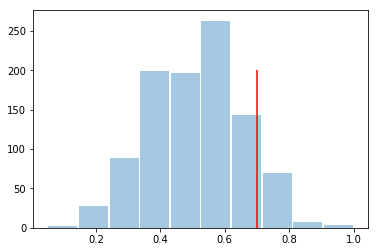

In [14]:
from matplotlib import pyplot as plt
permutation_auc=np.array(permutation_auc)
plt.hist(permutation_auc,rwidth=0.95,alpha=0.4)
plt.vlines(original_auc,0,200,label=str(original_auc),color='r')



The red line in the figure is that the original AUC, which is 0.7. So the right parts to the vertical line represents the 10.5% of all repetitions, means p-value is `0.105`.
So that these results are not statistically significant with α=0.05. 


## Lesson 2.2: sample size again

Let's give poor Tux a better data set that actually has clear difference between the classes and see how things work out. (on this data it is possible to obtain true AUC larger than 0.5)

In [15]:
def load_new_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X_pos = rand_state.randn(positives, features)
    X_neg = rand_state.randn(samples-positives, features)+0.65
    X = np.vstack((X_pos, X_neg))
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    I = rand_state.permutation(samples)
    X = X[I]
    y = y[I]
    return X, y

In [16]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_new_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print("AUC: %f" %cv_auc)
print('Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"')

AUC: 0.875000
Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"


## Question 2.2
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.



In [17]:
#implement permutation
original_auc=cv_auc #define the previous auc as "original" auc
permutation_auc=[]

for i in range(0,1000):
    rand_state = np.random.RandomState(i)#create a fixed random seed for each loop
    #=================#
    #shuffle labels
    y_shuffled=rand_state.permutation(y)
    #=================#
    #the five_fold_cv is the part used to implement cv, the same as the previous part
    permutation_auc.append(five_fold_cv(X,y_shuffled))#un the analysis and compute the AUC value.


In [18]:
#calculate the p-value of permutation test
p_value=float(len(np.where(permutation_auc>=original_auc)[0])/1000.0)
alpha=0.05
if p_value < alpha:
    print("{}<{},the result is significant".format(str(p_value),str(alpha)))
else:
    print("{}>{},the result is not significant".format(str(p_value),str(alpha)))


0.001<0.05,the result is significant


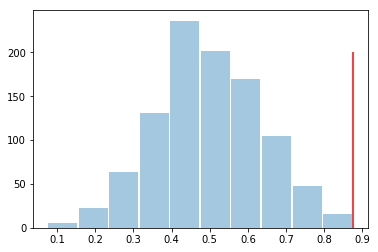

In [14]:
#Visualization
from matplotlib import pyplot as plt
permutation_auc=np.array(permutation_auc)
plt.hist(permutation_auc,rwidth=0.95,alpha=0.4)
plt.vlines(original_auc,0,200,label=str(original_auc),color='r')


The red line in the figure is that the original AUC, which is 0.875. So the right parts to the vertical line represents the 0.1% of all repetitions, means p-value is 0.001. So that these results are statistically significant with α=0.05. The model can find some connections between X and y.

# Part 3: mis-using feature selection

Here is a very simple correlation based feature selection method

In [24]:
from scipy.stats import kendalltau

def select(X, Y, scount):
    #select scount features from X with highest correlation with Y
    correlations = []
    for i in range(X.shape[1]):
        corr = kendalltau(X[:,i], Y)[0]
        correlations.append(np.abs(corr))
    correlations = np.array(correlations)
    I = np.argsort(correlations)
    I = I[::-1]
    return X[:,I[:scount]]

In [25]:
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC before feature selection is %f"' %cv_auc)


#I'm going to improve my AUC with feature selection!!!
X_fs = select(X, y, 5)
cv_aucs = []
for train, test in cv.split(X_fs, y):
    X_train = X_fs[train]
    y_train = y[train]
    X_test = X_fs[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC after feature selection is %f, it really works!!"' %cv_auc)

Tux: "My CV-AUC before feature selection is 0.496000"
Tux: "My CV-AUC after feature selection is 0.808000, it really works!!"


## Question 3.1

Use permutation test to show Tux that the feature selection based classification approach is actually not learning anything from the data ($\alpha=0.05$, provide both visualization of the permutation distribution, as well as the p-value). Running the test may take a while. Analyse what is going on here, why did the results look so good?

In [26]:
#implement permutation
original_auc=cv_auc #define the previous auc as "original" auc
permutation_auc=[]


for i in range(0,1000):
    rand_state = np.random.RandomState(i)#create a fixed random seed for each loop
    #=================#
    #shuffle labels
    y_shuffled=rand_state.permutation(y)
    #=================#
    #the five_fold_cv is the part used to implement cv, the same as the previous part
    X_fs = select(X, y_shuffled, 5)
    permutation_auc.append(five_fold_cv(X_fs,y_shuffled))#un the analysis and compute the AUC value.


In [28]:
#calculate the p-value of permutation test
p_value=float(len(np.where(permutation_auc>=original_auc)[0])/1000.0)
alpha=0.05
if p_value < alpha:
    print("{}<{},the result is significant".format(str(p_value),str(alpha)))
else:
    print("{}>{},the result is not significant".format(str(p_value),str(alpha)))


0.634>0.05,the result is not significant


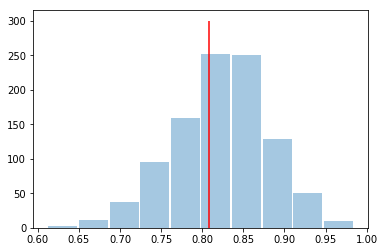

In [30]:
#Visualization
from matplotlib import pyplot as plt
permutation_auc=np.array(permutation_auc)
plt.hist(permutation_auc,rwidth=0.95,alpha=0.4)
plt.vlines(original_auc,0,300,label=str(original_auc),color='r')


The p-value is `0.634`, so that the null hypothesis should be rejected. which means that the the feature selection based classification approach learned nothing from the data. 
Also the even if for random data, the AUC is too high. This means the model is biased because it uses test data to do feature selection, which leads to over-optimistic.

## Question 3.2 (bonus exercise)

Correct the bias in above example by combining feature selection properly with cross-validation, run the experiment again. Do also a permutation test for this experiment with as many permutations as you can afford in a reasonable amount of time.

In [26]:
# re-write the select()function to get the selected feature index 
def select(X, Y, scount):
    #select scount features from X with highest correlation with y
    correlations = []
    for i in range(X.shape[1]):
        corr = kendalltau(X[:,i], Y)[0]
        correlations.append(np.abs(corr))
    correlations = np.array(correlations)
    I = np.argsort(correlations)
    I = I[::-1]
    return X[:,I[:scount]],I[:scount]

In [27]:
#capsulate feature selection based cv as a function
def fs_five_fold_cv(X,y):
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_train,feature_index=select(X_train, y_train, 5)#do feature selection on training set in each round 
#         pdb.set_trace()
        X_test = X[test][:,feature_index]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    cv_auc = np.mean(cv_aucs)
    return cv_auc


In [28]:
#implement permutation
X, y = load_mystery_data(50, 1000, 25, 1) #reload the data
original_auc=fs_five_fold_cv(X,y) #define the previous auc as "original" auc
permutation_auc=[]

for i in range(0,1000):
    
    rand_state = np.random.RandomState(i)#create a fixed random seed for each loop
    #=================#
    #shuffle labels
    y_shuffled=rand_state.permutation(y)
    #=================#
    #the five_fold_cv is the part used to implement cv, the same as the previous part
    permutation_auc.append(fs_five_fold_cv(X,y_shuffled))#run the analysis and compute the AUC value.


In [29]:
#calculate the p-value of permutation test
p_value=float(len(np.where(permutation_auc>=original_auc)[0])/1000.0)
alpha=0.05
if p_value < alpha:
    print("{}<{},the result is significant".format(str(p_value),str(alpha)))
else:
    print("{}>{},the result is not significant".format(str(p_value),str(alpha)))


0.513>0.05,the result is not significant


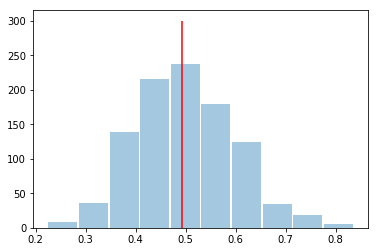

In [31]:
#Visualization
from matplotlib import pyplot as plt
permutation_auc=np.array(permutation_auc)
plt.hist(permutation_auc,rwidth=0.95,alpha=0.4)
plt.vlines(original_auc,0,300,label=str(original_auc),color='r')


Correct the bias in above example by combining feature selection properly with cross-validation, run the experiment again. Do also a permutation test for this experiment with as many permutations as you can afford in a reasonable amount of time.

The p-value is 0.513, and the results are not significant. We can't accept the hypothesis because this means that the model can't leanrn things from the data. But after modifying the feature selection I found that the original auc has been nearly 0.5 while results for random data are distributed unbiasedly. Compared to previous over-optimistic 0.808, I think this result should be relatively reasonable. It just shows that learning from non-signal data is difficult.